## Network analysis

Calculate and plot network metrics for the graphs created in the last step as well as some of the Google COVID-19 Mobility Report data for the relevant time periods.

In [1]:
from typing import List
import pickle
import networkx as nx
import matplotlib
from matplotlib import pyplot as plt
import seaborn

from data_processing.data_paths import OUT, GRAPHS, GRAPHICS

Read pickled data created in previous steps.

In [2]:
demographics = pickle.load(open(f'{OUT}demographics.pkl', 'rb'))

comb_counts_pre = pickle.load(open(f'{OUT}comb_counts_pre.pkl', 'rb'))
comb_counts_post = pickle.load(open(f'{OUT}comb_counts_post.pkl', 'rb'))

trip_counts_pre = pickle.load(open(f'{OUT}trip_counts_pre.pkl', 'rb'))
trip_counts_post = pickle.load(open(f'{OUT}trip_counts_post.pkl', 'rb'))

g_pre = nx.read_graphml(f'{GRAPHS}pre_N_10000.graphml')
g_post = nx.read_graphml(f'{GRAPHS}post_N_10000.graphml')

google_mobility_agg = pickle.load(open(f'{OUT}google_mobility_agg.pkl', 'rb'))

Store all CBG codes in order.

In [3]:
# store all CBGs in order
ordered_cbgs = sorted(demographics.keys())

Calculate density of the networks.

In [4]:
# density
def calc_density(graph: nx.Graph) -> float:
    num_edges = len(graph.edges)
    num_nodes = len(graph.nodes)
    num_edges_max = num_nodes * (num_nodes - 1) / 2
    return num_edges / num_edges_max

In [5]:
%%time
densities = [calc_density(g_pre), calc_density(g_post)]

CPU times: user 12.3 ms, sys: 36 µs, total: 12.3 ms
Wall time: 12.2 ms


Calculate the shortest path length of each pair of nodes in the networks.

In [6]:
# shortest path length

def calc_shortest_paths(graph: nx.Graph) -> List[int]:
    shortest_paths = []
    for x in nx.shortest_path_length(graph):
        shortest_paths.extend(list(x[1].values()))
    return shortest_paths

In [7]:
%%time
# takes very long.. only calculate if necessary

shortest_paths = []
shortest_paths.append(calc_shortest_paths(g_pre))
shortest_paths.append(calc_shortest_paths(g_post))

pickle.dump(shortest_paths, open(f'{OUT}shortest_paths.pkl', 'wb'))

CPU times: user 17min 16s, sys: 5.7 s, total: 17min 21s
Wall time: 17min 22s


In [8]:
shortest_paths = pickle.load(open(f'{OUT}shortest_paths.pkl', 'rb'))

Calculate the cluster coefficients for each networks.

In [9]:
# cluster coefficient
def calc_cluster_coeff(graph: nx.Graph) -> List[float]:
    coefficients = nx.clustering(graph)
    return list(coefficients.values())

In [10]:
%%time

clustering_coeffs = []
clustering_coeffs.append(calc_cluster_coeff(g_pre))
clustering_coeffs.append(calc_cluster_coeff(g_post))

CPU times: user 461 ms, sys: 0 ns, total: 461 ms
Wall time: 460 ms


Extract the network degrees.

In [11]:
%%time
degrees = [list(dict(g_pre.degree()).values()), 
           list(dict(g_post.degree()).values())]

CPU times: user 28.2 ms, sys: 0 ns, total: 28.2 ms
Wall time: 27.1 ms


### Visualisations

Define helper functions for plotting.

In [12]:
# set the colors of pairs of boxplots to red and blue.
def set_boxplot_colors(bp):
    bp['medians'][0].set_color('firebrick')
    bp['medians'][1].set_color('steelblue')
    
    bp['boxes'][0].set_color('firebrick')
    bp['boxes'][1].set_color('steelblue')
    
    bp['caps'][0].set_color('firebrick')
    bp['caps'][1].set_color('firebrick')
    bp['caps'][2].set_color('steelblue')
    bp['caps'][3].set_color('steelblue')
    
    bp['whiskers'][0].set_color('firebrick')
    bp['whiskers'][1].set_color('firebrick')
    bp['whiskers'][2].set_color('steelblue')
    bp['whiskers'][3].set_color('steelblue')

Visualise the trip counts of the Patterns data and data from the Google COVID-19 Mobility Report.

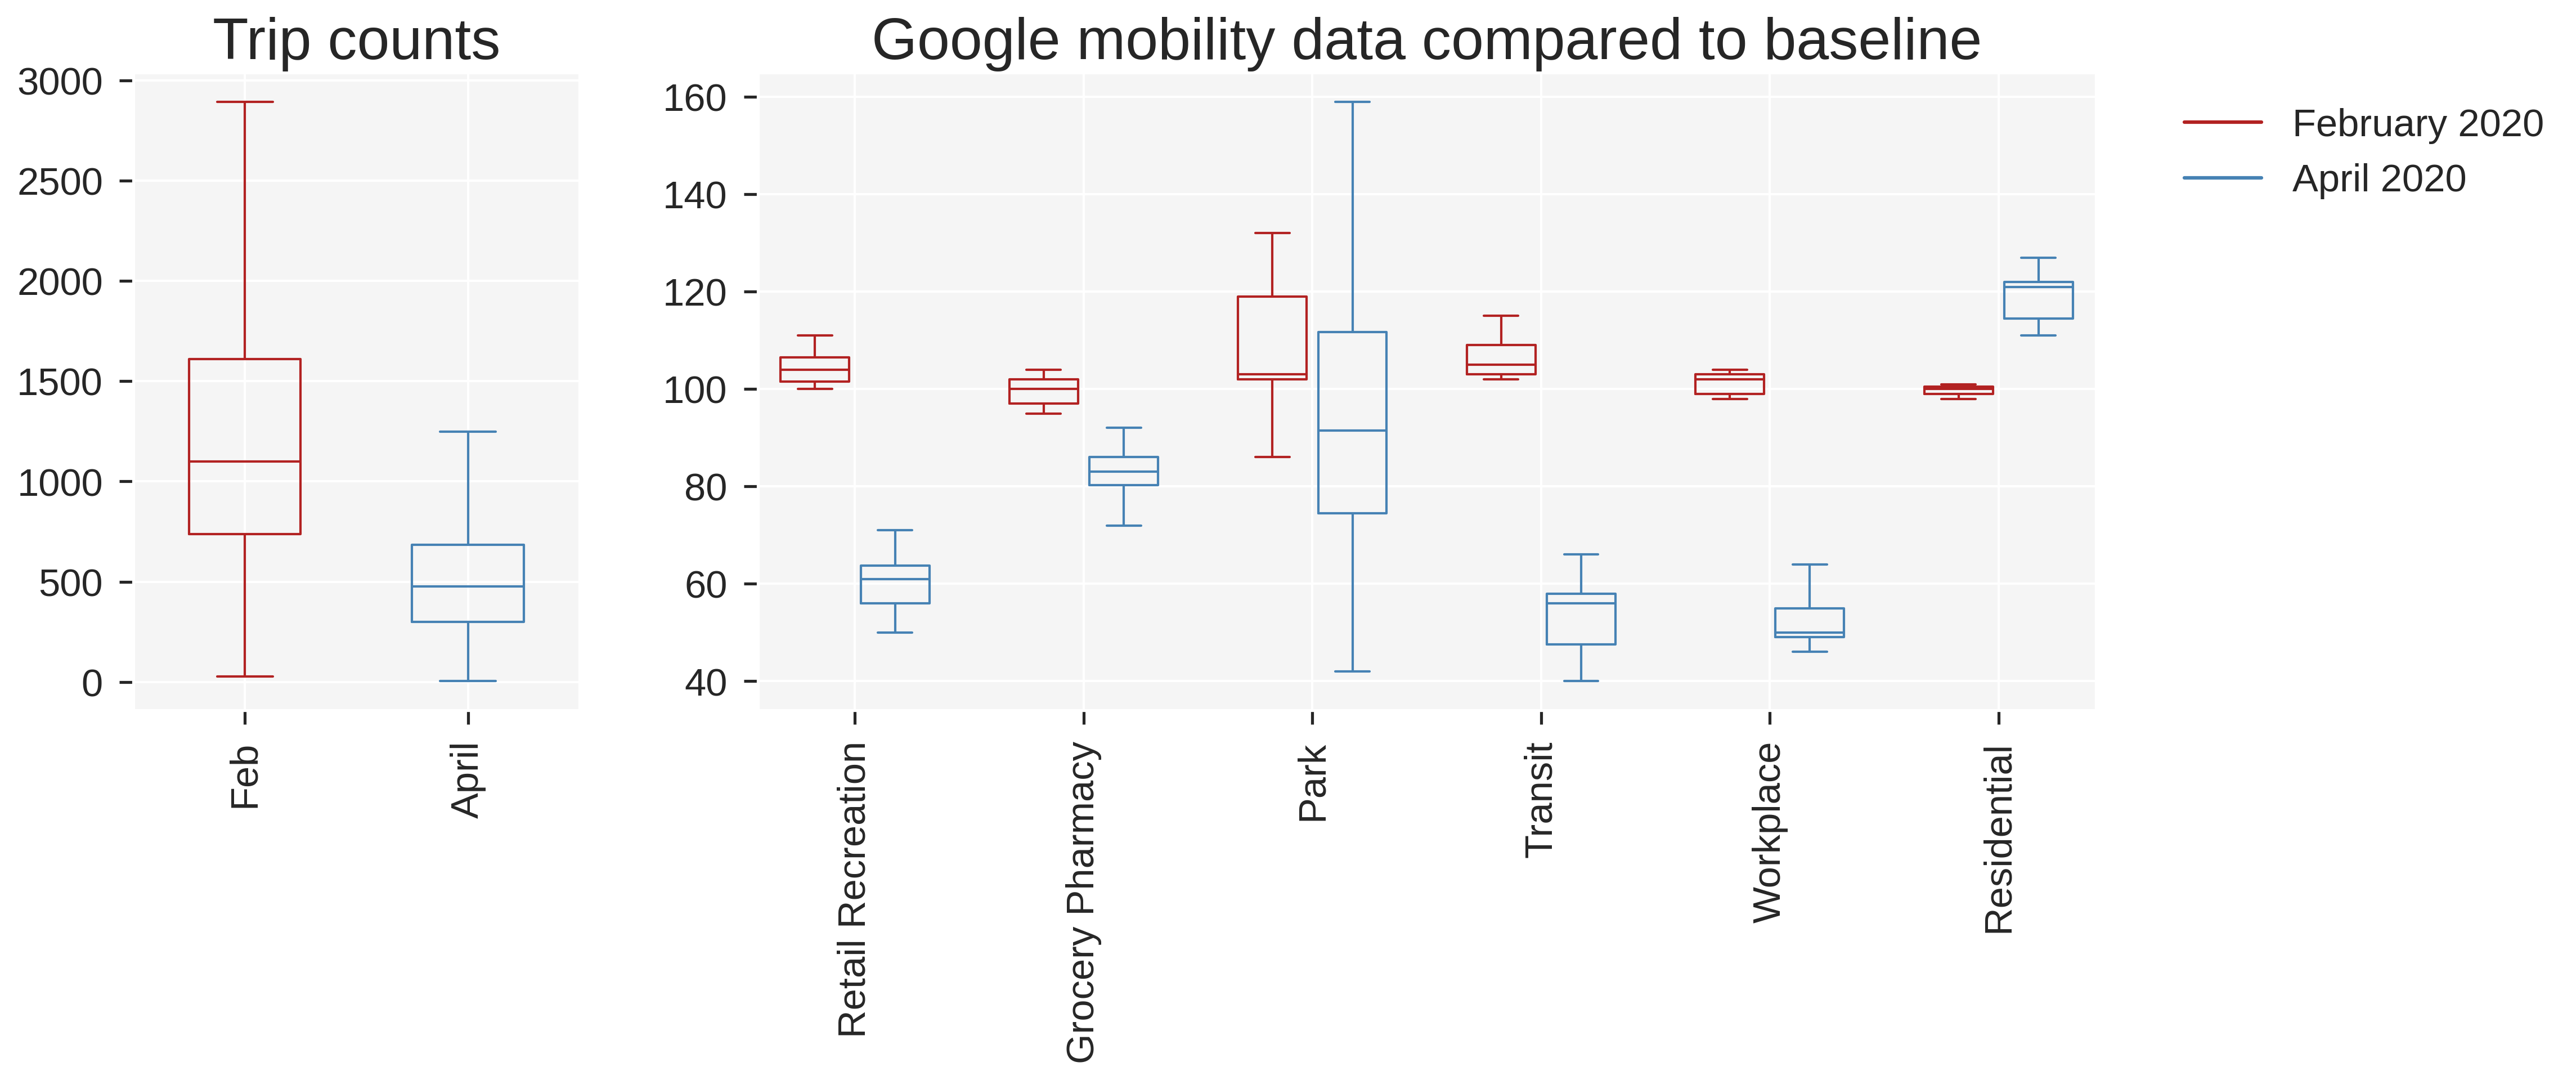

In [13]:
matplotlib.style.use('seaborn')
matplotlib.rcParams['figure.dpi'] = 300
seaborn.set_context('notebook', font_scale=1.5)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), facecolor='w', gridspec_kw={'width_ratios': [1, 3]})

# trip counts
data_trips = [list(trip_counts_pre.values()), list(trip_counts_post.values())]
bp = ax1.boxplot(data_trips, showfliers=False, widths=0.5)
set_boxplot_colors(bp)

ax1.set_facecolor('#F5F5F5')
ax1.set_title('Trip counts', fontsize=25)
ax1.set_xticks([1, 2])
ax1.set_xticklabels(['Feb', 'April'], rotation=90)

# google
categories = [' '.join([w.capitalize() for w in x.split('_')]) 
              for x in google_mobility_agg[2].keys()]

c = 1
for k in google_mobility_agg[2].keys():
    data = [google_mobility_agg[2][k], google_mobility_agg[4][k]]
    bp = ax2.boxplot(data, positions = [c+0.15, c+0.85], widths=0.6, showfliers=False)
    set_boxplot_colors(bp)
    
    c += 2

ax2.set_title('Google mobility data compared to baseline', fontsize=25)
ax2.set_xticks([1.5 + i*2 for i, _ in enumerate(categories)])
ax2.set_xticklabels(list(categories), rotation=90)
ax2.set_facecolor('#F5F5F5')

_ = plt.plot([], color='firebrick', label='February 2020', ls='-')
_ = plt.plot([], color='steelblue', label='April 2020')
_ = plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

plt.savefig(f'{GRAPHICS}mobility-metrics.png', bbox_inches="tight")
plt.show()

Visualise network metrics for both graphs.

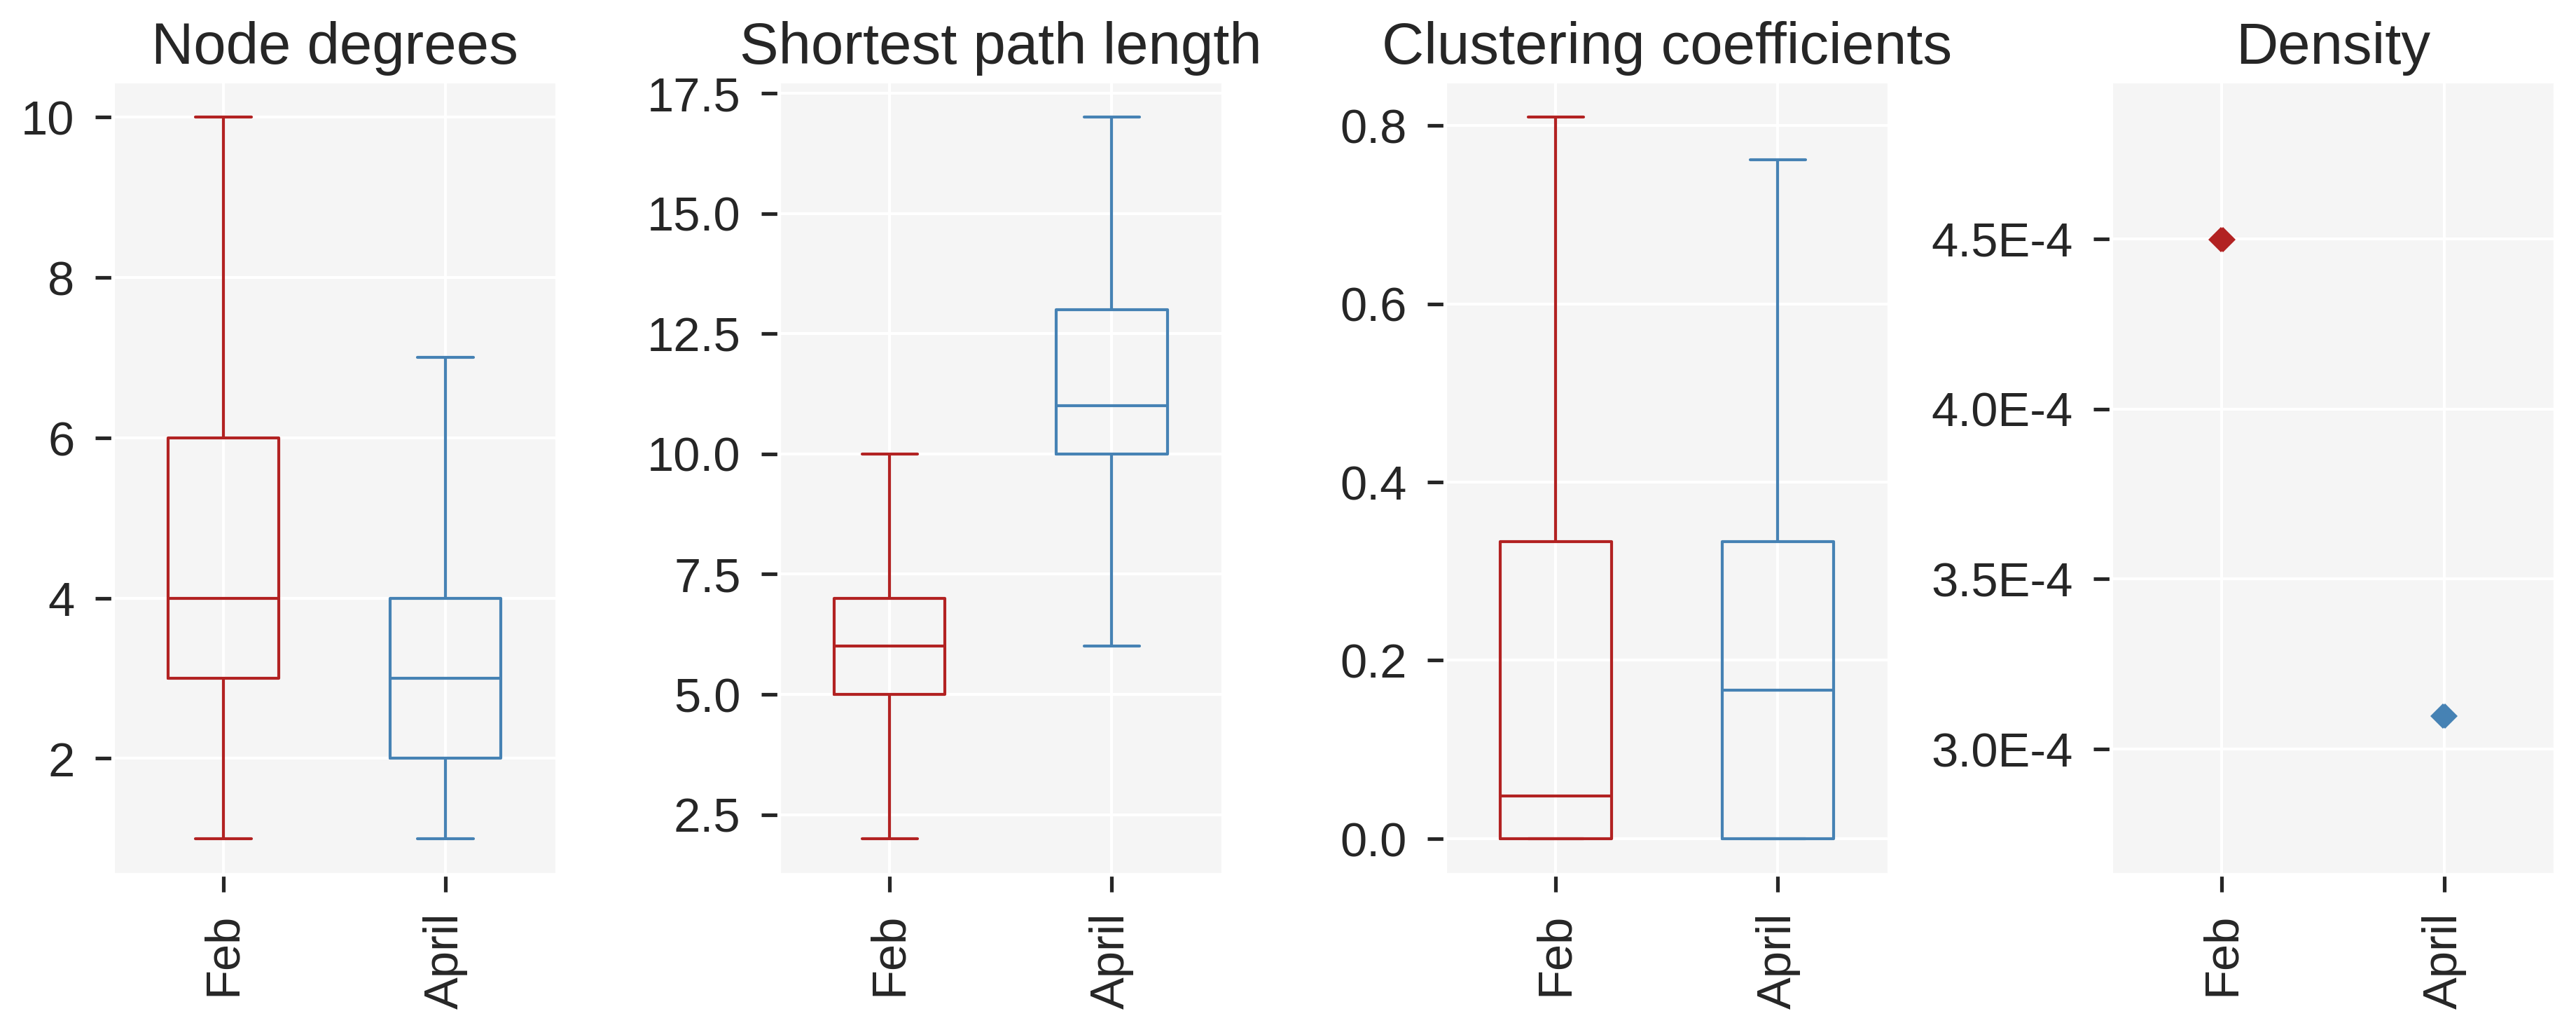

In [14]:
matplotlib.style.use('seaborn')
matplotlib.rcParams['figure.dpi'] = 300
seaborn.set_context('notebook', font_scale=1.5)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15,5), facecolor='w', 
                                         gridspec_kw={'width_ratios': [1, 1, 1, 1]})

# degrees
data_degrees = degrees
bp = ax1.boxplot(data_degrees, showfliers=False, widths=0.5)
set_boxplot_colors(bp)

ax1.set_facecolor('#F5F5F5')
ax1.set_title('Node degrees', fontsize=20)
ax1.set_xticks([1, 2])
ax1.set_xticklabels(['Feb', 'April'], rotation=90)

# shortest path
data_shortest_path = shortest_paths
bp = ax2.boxplot(data_shortest_path, showfliers=False, widths=0.5)
set_boxplot_colors(bp)

ax2.set_facecolor('#F5F5F5')
ax2.set_title('Shortest path length', fontsize=20)
ax2.set_xticks([1, 2])
ax2.set_xticklabels(['Feb', 'April'], rotation=90)

# clustering coefficient
data_clustering = clustering_coeffs
bp = ax3.boxplot(data_clustering, showfliers=False, widths=0.5)
set_boxplot_colors(bp)

ax3.set_facecolor('#F5F5F5')
ax3.set_title('Clustering coefficients', fontsize=20)
ax3.set_xticks([1, 2])
ax3.set_xticklabels(['Feb', 'April'], rotation=90)

# density
medianprops = dict(linewidth=4, marker='D')
data_density = [[densities[0]], [densities[1]]]
bp = ax4.boxplot(data_density, showfliers=False, medianprops=medianprops, widths=0.01)
set_boxplot_colors(bp)

margin = abs(densities[0] - densities[1]) / 3
y_low = min(densities[0], densities[1]) - margin
y_up = max(densities[0], densities[1]) + margin

fmt = lambda x, _: '{:.1f}'.format(x*10000) + 'E-4'

ax4.set_ylim(y_low, y_up)
ax4.yaxis.set_major_formatter(fmt)
ax4.set_facecolor('#F5F5F5')
ax4.set_title('Density', fontsize=20)
ax4.set_xticks([1, 2])
ax4.set_xticklabels(['Feb', 'April'], rotation=90)

plt.subplots_adjust(wspace=0.5)
plt.savefig(f'{GRAPHICS}network-metrics.png', bbox_inches="tight")
plt.show()